In [4]:
pip install pandas numpy matplotlib seaborn ucimlrepo scikit-learn==1.7.0 joblib

  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Import Dependencies

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, validation_curve, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import joblib
import warnings
warnings.filterwarnings('ignore')

try:
    from xgboost import XGBClassifier
except ImportError:
    XGBClassifier = None
    print("Install XGBoost using: pip install xgboost")

try:
    import shap
except ImportError:
    shap = None
    print("Install SHAP using: pip install shap")

# Loading Dataset ( UCI Heart Dataset )

In [2]:
# 1. Fetch dataset
heart_disease = fetch_ucirepo(id=45)
X = heart_disease.data.features
y = heart_disease.data.targets


# Making Folders to save EDA Plots and Test Metrics

In [3]:
# Create directories
os.makedirs("models", exist_ok=True)
os.makedirs("plots", exist_ok=True)

# Exploratory Data Analysis

Starting EDA...
EDA plots saved successfully!


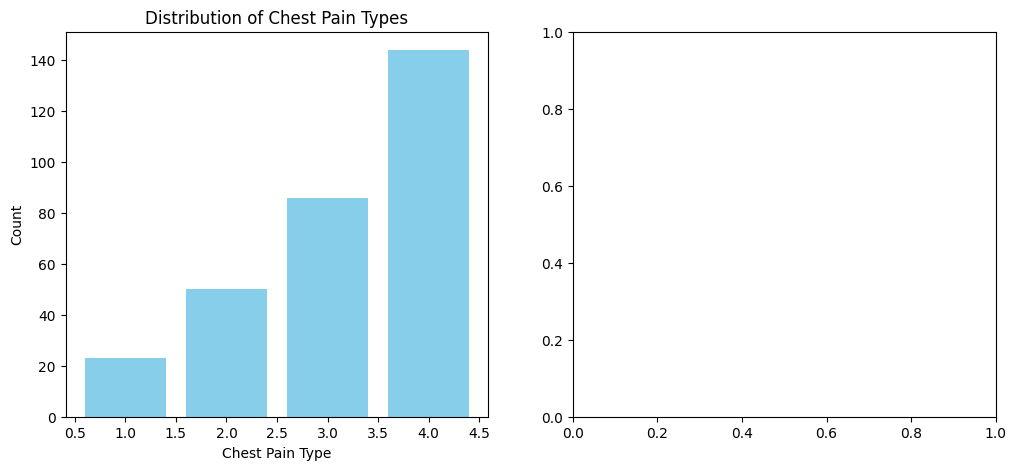

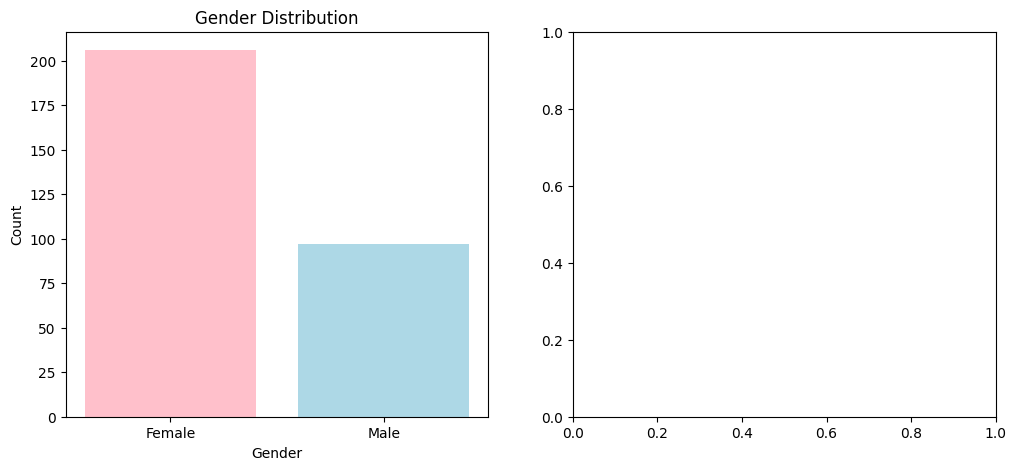

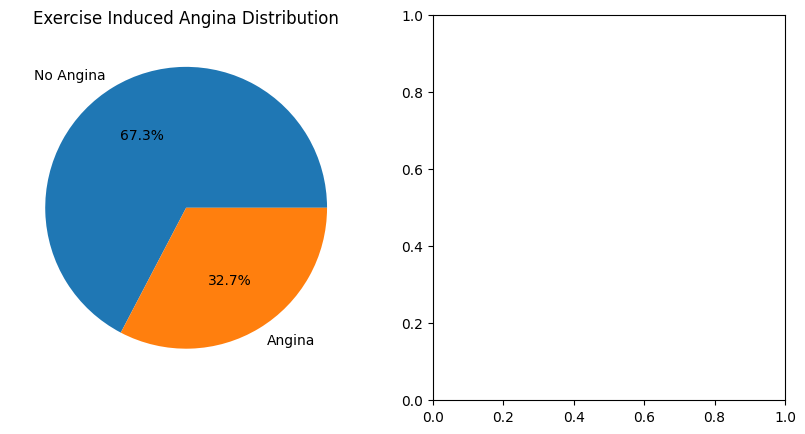

<Figure size 1200x1000 with 0 Axes>

In [4]:
# 2. Target encoding: 0 = no disease, 1 = disease
if isinstance(y, pd.DataFrame):
    y = y.iloc[:, 0]
y = y.apply(lambda x: 1 if x > 0 else 0)

# Create a combined dataset for EDA
data = X.copy()
data['target'] = y

print("Starting EDA...")

# =============================================================================
# EXPLORATORY DATA ANALYSIS (EDA) - 10+ PLOTS
# =============================================================================

# 1. Target Distribution
plt.figure(figsize=(8, 6))
target_counts = data['target'].value_counts()
plt.pie(target_counts.values, labels=['No Disease', 'Disease'], autopct='%1.1f%%', 
        colors=['lightblue', 'lightcoral'])
plt.title('Distribution of Heart Disease')
plt.savefig('plots/01_target_distribution.png', dpi=300, bbox_inches='tight')
plt.close()

# 2. Age Distribution by Target
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(data[data['target']==0]['age'], alpha=0.7, label='No Disease', bins=20)
plt.hist(data[data['target']==1]['age'], alpha=0.7, label='Disease', bins=20)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution by Heart Disease')
plt.legend()

plt.subplot(1, 2, 2)
sns.boxplot(data=data, x='target', y='age')
plt.xlabel('Heart Disease')
plt.ylabel('Age')
plt.title('Age vs Heart Disease')
plt.xticks([0, 1], ['No Disease', 'Disease'])
plt.tight_layout()
plt.savefig('plots/02_age_analysis.png', dpi=300, bbox_inches='tight')
plt.close()

# 3. Correlation Heatmap
plt.figure(figsize=(14, 12))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f')
plt.title('Correlation Matrix of All Features')
plt.tight_layout()
plt.savefig('plots/03_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.close()

# 4. Chest Pain Type Analysis
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
cp_counts = data['cp'].value_counts().sort_index()
plt.bar(cp_counts.index, cp_counts.values, color='skyblue')
plt.xlabel('Chest Pain Type')
plt.ylabel('Count')
plt.title('Distribution of Chest Pain Types')

plt.subplot(1, 2, 2)
cp_target = pd.crosstab(data['cp'], data['target'], normalize='index')
cp_target.plot(kind='bar', stacked=True, color=['lightblue', 'lightcoral'])
plt.xlabel('Chest Pain Type')
plt.ylabel('Proportion')
plt.title('Heart Disease by Chest Pain Type')
plt.legend(['No Disease', 'Disease'])
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('plots/04_chest_pain_analysis.png', dpi=300, bbox_inches='tight')
plt.close()

# 5. Gender Analysis
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sex_counts = data['sex'].value_counts()
plt.bar(['Female', 'Male'], sex_counts.values, color=['pink', 'lightblue'])
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')

plt.subplot(1, 2, 2)
sex_target = pd.crosstab(data['sex'], data['target'], normalize='index')
sex_target.plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.xlabel('Gender')
plt.ylabel('Proportion')
plt.title('Heart Disease by Gender')
plt.legend(['No Disease', 'Disease'])
plt.xticks([0, 1], ['Female', 'Male'], rotation=0)
plt.tight_layout()
plt.savefig('plots/05_gender_analysis.png', dpi=300, bbox_inches='tight')
plt.close()

# 6. Blood Pressure Analysis
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.scatter(data[data['target']==0]['trestbps'], data[data['target']==0]['age'], 
           alpha=0.6, label='No Disease')
plt.scatter(data[data['target']==1]['trestbps'], data[data['target']==1]['age'], 
           alpha=0.6, label='Disease')
plt.xlabel('Resting Blood Pressure')
plt.ylabel('Age')
plt.title('Blood Pressure vs Age')
plt.legend()

plt.subplot(1, 2, 2)
sns.boxplot(data=data, x='target', y='trestbps')
plt.xlabel('Heart Disease')
plt.ylabel('Resting Blood Pressure')
plt.title('Blood Pressure by Heart Disease')
plt.xticks([0, 1], ['No Disease', 'Disease'])
plt.tight_layout()
plt.savefig('plots/06_blood_pressure_analysis.png', dpi=300, bbox_inches='tight')
plt.close()

# 7. Cholesterol Analysis
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
# Remove zero values for better visualization
chol_data = data[data['chol'] > 0]
plt.hist(chol_data[chol_data['target']==0]['chol'], alpha=0.7, label='No Disease', bins=20)
plt.hist(chol_data[chol_data['target']==1]['chol'], alpha=0.7, label='Disease', bins=20)
plt.xlabel('Cholesterol')
plt.ylabel('Frequency')
plt.title('Cholesterol Distribution')
plt.legend()

plt.subplot(1, 2, 2)
sns.boxplot(data=chol_data, x='target', y='chol')
plt.xlabel('Heart Disease')
plt.ylabel('Cholesterol')
plt.title('Cholesterol by Heart Disease')
plt.xticks([0, 1], ['No Disease', 'Disease'])
plt.tight_layout()
plt.savefig('plots/07_cholesterol_analysis.png', dpi=300, bbox_inches='tight')
plt.close()

# 8. Maximum Heart Rate Analysis
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(data[data['target']==0]['thalach'], alpha=0.7, label='No Disease', bins=20)
plt.hist(data[data['target']==1]['thalach'], alpha=0.7, label='Disease', bins=20)
plt.xlabel('Maximum Heart Rate')
plt.ylabel('Frequency')
plt.title('Max Heart Rate Distribution')
plt.legend()

plt.subplot(1, 2, 2)
sns.boxplot(data=data, x='target', y='thalach')
plt.xlabel('Heart Disease')
plt.ylabel('Maximum Heart Rate')
plt.title('Max Heart Rate by Heart Disease')
plt.xticks([0, 1], ['No Disease', 'Disease'])
plt.tight_layout()
plt.savefig('plots/08_max_heart_rate_analysis.png', dpi=300, bbox_inches='tight')
plt.close()

# 9. Exercise Induced Angina Analysis
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
exang_counts = data['exang'].value_counts()
plt.pie(exang_counts.values, labels=['No Angina', 'Angina'], autopct='%1.1f%%')
plt.title('Exercise Induced Angina Distribution')

plt.subplot(1, 2, 2)
exang_target = pd.crosstab(data['exang'], data['target'], normalize='index')
exang_target.plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.xlabel('Exercise Induced Angina')
plt.ylabel('Proportion')
plt.title('Heart Disease by Exercise Angina')
plt.legend(['No Disease', 'Disease'])
plt.xticks([0, 1], ['No Angina', 'Angina'], rotation=0)
plt.tight_layout()
plt.savefig('plots/09_exercise_angina_analysis.png', dpi=300, bbox_inches='tight')
plt.close()

# 10. ST Depression Analysis
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.scatter(data[data['target']==0]['oldpeak'], data[data['target']==0]['thalach'], 
           alpha=0.6, label='No Disease')
plt.scatter(data[data['target']==1]['oldpeak'], data[data['target']==1]['thalach'], 
           alpha=0.6, label='Disease')
plt.xlabel('ST Depression')
plt.ylabel('Max Heart Rate')
plt.title('ST Depression vs Max Heart Rate')
plt.legend()

plt.subplot(1, 2, 2)
sns.boxplot(data=data, x='target', y='oldpeak')
plt.xlabel('Heart Disease')
plt.ylabel('ST Depression')
plt.title('ST Depression by Heart Disease')
plt.xticks([0, 1], ['No Disease', 'Disease'])
plt.tight_layout()
plt.savefig('plots/10_st_depression_analysis.png', dpi=300, bbox_inches='tight')
plt.close()

# 11. Pairplot of Key Numerical Features
plt.figure(figsize=(12, 10))
key_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'target']
sns.pairplot(data[key_features], hue='target', diag_kind='hist')
plt.suptitle('Pairplot of Key Features', y=1.02)
plt.savefig('plots/11_pairplot_key_features.png', dpi=300, bbox_inches='tight')
plt.close()

# 12. Feature Distribution Grid
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope']

for i, feature in enumerate(numerical_features):
    row, col = i // 4, i % 4
    axes[row, col].hist(data[data['target']==0][feature], alpha=0.7, label='No Disease', bins=15)
    axes[row, col].hist(data[data['target']==1][feature], alpha=0.7, label='Disease', bins=15)
    axes[row, col].set_title(f'{feature} Distribution')
    axes[row, col].legend()

for i, feature in enumerate(categorical_features):
    row, col = (i + 6) // 4, (i + 6) % 4
    cross_tab = pd.crosstab(data[feature], data['target'], normalize='index')
    cross_tab.plot(kind='bar', ax=axes[row, col], color=['lightblue', 'lightcoral'])
    axes[row, col].set_title(f'{feature} vs Target')
    axes[row, col].legend(['No Disease', 'Disease'])
    axes[row, col].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('plots/12_feature_distributions_grid.png', dpi=300, bbox_inches='tight')
plt.close()

print("EDA plots saved successfully!")

# Model Training ( Regression )

In [5]:
# 3. One-hot encode categorical features
categorical = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
X = pd.get_dummies(X, columns=[col for col in categorical if col in X.columns], drop_first=True)

# 4. Save a sample input template for inference alignment
X.iloc[[0]].to_json("models/sample_input.json")

# 5. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 6. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, "models/scaler.joblib")

# 7. Train models and generate evaluation plots
models = {}
model_names = []

# Logistic Regression
print("Training Logistic Regression...")
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
joblib.dump(lr, "models/logistic_regression_model_new.joblib")
models['Logistic Regression'] = lr
model_names.append('Logistic Regression')

# Random Forest
print("Training Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
joblib.dump(rf, "models/random_forest_model.joblib")
models['Random Forest'] = rf
model_names.append('Random Forest')

# XGBoost
if XGBClassifier:
    print("Training XGBoost...")
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb.fit(X_train_scaled, y_train)
    joblib.dump(xgb, "models/xgboost_model.joblib")
    models['XGBoost'] = xgb
    model_names.append('XGBoost')

Training Logistic Regression...
Training Random Forest...
Training XGBoost...


# Model Evaluation

In [6]:
print("Generating model evaluation plots...")

# 1. Confusion Matrices
fig, axes = plt.subplots(1, len(models), figsize=(5*len(models), 4))
if len(models) == 1:
    axes = [axes]

for i, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{name} - Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('plots/13_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.close()

# 2. ROC Curves
plt.figure(figsize=(10, 8))
for name, model in models.items():
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_proba = model.decision_function(X_test_scaled)
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig('plots/14_roc_curves.png', dpi=300, bbox_inches='tight')
plt.close()

# 3. Learning Curves (Fixed version)
fig, axes = plt.subplots(1, len(models), figsize=(6*len(models), 5))
if len(models) == 1:
    axes = [axes]

for i, (name, model) in enumerate(models.items()):
    try:
        # Use fewer jobs to avoid memory issues
        train_sizes, train_scores, val_scores = learning_curve(
            model, X_train_scaled, y_train, cv=3, n_jobs=1,  # Changed cv=3 and n_jobs=1
            train_sizes=np.linspace(0.2, 1.0, 8), random_state=42  # Fewer training sizes
        )
        
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)
        
        axes[i].plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
        axes[i].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
        
        axes[i].plot(train_sizes, val_mean, 'o-', color='red', label='Validation Score')
        axes[i].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
        
        axes[i].set_xlabel('Training Set Size')
        axes[i].set_ylabel('Accuracy Score')
        axes[i].set_title(f'{name} - Learning Curve')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        
    except Exception as e:
        print(f"Warning: Could not generate learning curve for {name}: {str(e)}")
        # Create a placeholder plot
        axes[i].text(0.5, 0.5, f"Learning curve\nunavailable for\n{name}", 
                    ha='center', va='center', transform=axes[i].transAxes, fontsize=12)
        axes[i].set_title(f'{name} - Learning Curve (Error)')
        axes[i].set_xlabel('Training Set Size')
        axes[i].set_ylabel('Accuracy Score')

plt.tight_layout()
plt.savefig('plots/15_learning_curves.png', dpi=300, bbox_inches='tight')
plt.close()

# 4. Feature Importance (for tree-based models)
feature_importance_models = {k: v for k, v in models.items() if hasattr(v, 'feature_importances_')}

if feature_importance_models:
    fig, axes = plt.subplots(1, len(feature_importance_models), figsize=(8*len(feature_importance_models), 6))
    if len(feature_importance_models) == 1:
        axes = [axes]
    
    for i, (name, model) in enumerate(feature_importance_models.items()):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:15]  # Top 15 features
        
        axes[i].bar(range(len(indices)), importances[indices])
        axes[i].set_title(f'{name} - Feature Importance')
        axes[i].set_xlabel('Features')
        axes[i].set_ylabel('Importance')
        axes[i].set_xticks(range(len(indices)))
        axes[i].set_xticklabels([X.columns[i] for i in indices], rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('plots/16_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.close()

# 5. SHAP Analysis (if available) - Modified for safety
try:
    if 'shap' in globals() and shap is not None:
        print("Generating SHAP plots...")
        
        # SHAP for Random Forest
        if 'Random Forest' in models:
            explainer = shap.TreeExplainer(models['Random Forest'])
            # Use smaller sample for SHAP to avoid memory issues
            sample_size = min(100, len(X_test_scaled))
            X_sample = X_test_scaled.sample(n=sample_size, random_state=42) if hasattr(X_test_scaled, 'sample') else X_test_scaled[:sample_size]
            shap_values = explainer.shap_values(X_sample)
            
            # Summary plot
            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values[1], X_sample, feature_names=X.columns, show=False)
            plt.title('SHAP Summary Plot - Random Forest')
            plt.tight_layout()
            plt.savefig('plots/17_shap_summary.png', dpi=300, bbox_inches='tight')
            plt.close()
            
            # Feature importance plot
            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values[1], X_sample, feature_names=X.columns, plot_type="bar", show=False)
            plt.title('SHAP Feature Importance - Random Forest')
            plt.tight_layout()
            plt.savefig('plots/18_shap_importance.png', dpi=300, bbox_inches='tight')
            plt.close()
    else:
        print("SHAP not available - skipping SHAP analysis")
except Exception as e:
    print(f"Warning: SHAP analysis failed: {str(e)}")

# 6. Model Performance Comparison
accuracies = []
model_names = list(models.keys())

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'lightcoral'][:len(model_names)])
plt.title('Model Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('plots/19_model_comparison.png', dpi=300, bbox_inches='tight')
plt.close()

# =============================================================================
# PRINT PERFORMANCE METRICS
# =============================================================================

print("\n" + "="*60)
print("MODEL PERFORMANCE RESULTS")
print("="*60)

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    print(f"\n--- {name} ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))

print("\n✅ All models, plots, and analysis saved successfully!")
print("📊 EDA plots saved in: /plots/01_*.png to /plots/12_*.png")
print("🤖 Model evaluation plots saved in: /plots/13_*.png to /plots/19_*.png")
print("💾 Models saved in: /models/ directory")

Generating model evaluation plots...
Generating SHAP plots...

MODEL PERFORMANCE RESULTS

--- Logistic Regression ---
Accuracy: 0.8525
              precision    recall  f1-score   support

           0       0.88      0.85      0.86        33
           1       0.83      0.86      0.84        28

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61


--- Random Forest ---
Accuracy: 0.8689
              precision    recall  f1-score   support

           0       0.90      0.85      0.88        33
           1       0.83      0.89      0.86        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61


--- XGBoost ---
Accuracy: 0.8525
              precision    recall  f1-score   support

           0       0.88      0.85      0.86        33
           1       0.83     

<Figure size 1000x800 with 0 Axes>